# Web Scraping and Sentiment Analysis of British Airways Reviews
### *by Alejandra Sevilla*
---

This Jupyter notebook shows the end-to-end process of collecting, cleaning, analyzing, and visualizing review data for British Airways from [Skytrax](https://www.airlinequality.com/airline-reviews/british-airways)
.

## Overview:

The workflow is structured as follows:

1. **Web Scraping:** Customer reviews are collected directly from Skytrax using `BeautifulSoup` and `requests`.

2. **Data Cleaning:** The reviews are processed to remove unneeded elements, normalize text, and prepare it for analysis.

3. **Sentiment Analysis:** Each review is analyzed to classify sentiment as Positive, Negative, or Neutral.

4. **Word Clouds:** Terms from positive and negative reviews are visualized to identify main themes.

5. **Topic Modeling:** Latent Dirichlet Allocation (LDA) is used to extract hidden topics from the text.

6. **N-grams Analysis:** Frequent phrases (bigrams and trigrams) are extracted to understand common expressions.

7. **Visualizations:** Results are visualized through bar charts, histograms, and word clouds.

## Libraries Used:

- **Web Scraping:** `BeautifulSoup`, `requests`

- **Data Processing:** `pandas, nltk, re`

- **Sentiment Analysis:** `TextBlob`

- **Visualization:** `matplotlib`, `seaborn`, `WordCloud`

- **Topic Modeling:** `scikit-learn`, `pyLDAvis`





## 1. Web Scraping - Collecting Reviews from Skytrax  

Customer reviews were collected directly from the Skytrax website using `BeautifulSoup` and `requests`.  
The target URL was configured to scrape up to 10 pages of review data, with 100 reviews per page, resulting in a dataset of 1000 customer reviews.

The scraping process included:
- Navigating through paginated content to extract all reviews.
- Parsing the HTML structure to locate the review text.
- Storing the collected data into a `DataFrame` for processing.

The data was saved locally in a CSV file.


In [1]:
# --- All Libraries ---
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis
import pyLDAvis.sklearn

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

# --- Configuration ---
BASE_URL = "https://www.airlinequality.com/airline-reviews/british-airways"
PAGES = 10
PAGE_SIZE = 100
OUTPUT_CSV = "../data/BA_reviews.csv"

# --- Scraping Function ---
def scrape_reviews(base_url, pages, page_size):
    reviews = []
    for i in range(1, pages + 1):
        print(f"Scraping page {i}")
        url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"
        response = requests.get(url)
        content = response.content
        parsed_content = BeautifulSoup(content, 'html.parser')
        for para in parsed_content.find_all("div", {"class": "text_content"}):
            reviews.append(para.get_text())
        print(f"   ---> {len(reviews)} total reviews")

    df = pd.DataFrame()
    df["reviews"] = reviews
    df.to_csv(OUTPUT_CSV, index=False)
    print(f"\nData saved to {OUTPUT_CSV}")
    return df

# --- Main Execution ---
print("Starting Web Scraping...")
df = scrape_reviews(BASE_URL, PAGES, PAGE_SIZE)


/Users/alejandrasevilla/Documents/ba-data-simulation/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alejandrasevilla/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/alejandrasevilla/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Starting Web Scraping...
Scraping page 1
   ---> 100 total reviews
Scraping page 2
   ---> 200 total reviews
Scraping page 3
   ---> 300 total reviews
Scraping page 4
   ---> 400 total reviews
Scraping page 5
   ---> 500 total reviews
Scraping page 6
   ---> 600 total reviews
Scraping page 7
   ---> 700 total reviews
Scraping page 8
   ---> 800 total reviews
Scraping page 9
   ---> 900 total reviews
Scraping page 10
   ---> 1000 total reviews

Data saved to ../data/BA_reviews.csv


## 2. Data Preview  

A quick inspection of the first few rows of the dataset to understand its structure and verify that the reviews were collected correctly.  


In [2]:
# --- Data Preview ---
print("Data Preview:")
df.head()

Data Preview:


,reviews
0,✅ Trip Verified | Check-in was slow with onl...
1,Not Verified | Check in was smooth enough. Bo...
2,✅ Trip Verified | Although transferring to thi...
3,✅ Trip Verified | We are extremely grateful ...
4,✅ Trip Verified | I had an appalling experie...


## 3. Data Cleaning  

The review text was cleaned to prepare for analysis. The cleaning steps included:  
- Removing verification labels such as `Trip Verified` and `Not Verified`.  
- Normalizing mentions of "British Airways" to a single token (`british_airways`).  
- Removing punctuation and numerical characters.  
- Converting all text to lowercase.  
- Eliminating stop words and applying lemmatization to each word.  


In [3]:
# Initialize stopwords and lemmatizer
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

# --- Data Cleaning Function ---
def clean_review(text):
    """
    Cleans a customer review by:
    - Removing verification labels
    - Lowercasing text
    - Removing punctuation and numbers
    - Normalizing key terms (e.g. British Airways)
    - Removing stopwords
    - Lemmatizing each word
    - Removing extra whitespace
    """
    text = re.sub(r"(✅)?\s*Trip Verified\s*\|?\s*", "", text)
    text = re.sub(r"Not Verified\s*\|?\s*", "", text)
    text = text.lower()
    text = re.sub(r"\b(british airways|ba)\b", "british_airways", text)
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    text = re.sub(r"\d+", "", text)
    words = text.split()
    words = [word for word in words if word not in stop_words]
    words = [lemmatizer.lemmatize(word) for word in words]
    text = " ".join(words)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# --- Apply Cleaning ---
df["clean_review"] = df["reviews"].apply(clean_review)
df = df[df["clean_review"].str.split().str.len() > 3]

# --- Data Preview after Cleaning ---
print("Data after Cleaning:")
df.head()


Data after Cleaning:


,reviews,clean_review
0,✅ Trip Verified | Check-in was slow with onl...,checkin slow one staff member checking economy...
1,Not Verified | Check in was smooth enough. Bo...,check smooth enough boarding chaotic herded ga...
2,✅ Trip Verified | Although transferring to thi...,although transferring flight heathrow budapest...
3,✅ Trip Verified | We are extremely grateful ...,extremely grateful crew flight ba cape town he...
4,✅ Trip Verified | I had an appalling experie...,appalling experience britishairways started tr...


## 4. Data Exploration  

The cleaned dataset was initially explored to get the following:  
- Total number of reviews  
- Average review length (in characters)  
- Top 10 most frequent words  
- Distribution of review lengths  
- Total count of unique words  


Total reviews: 1000
Average review length: 555.47 characters

Top 10 most frequent words:
flight: 2273
britishairways: 1688
seat: 820
service: 771
time: 667
hour: 617
airline: 477
crew: 467
one: 442
u: 439


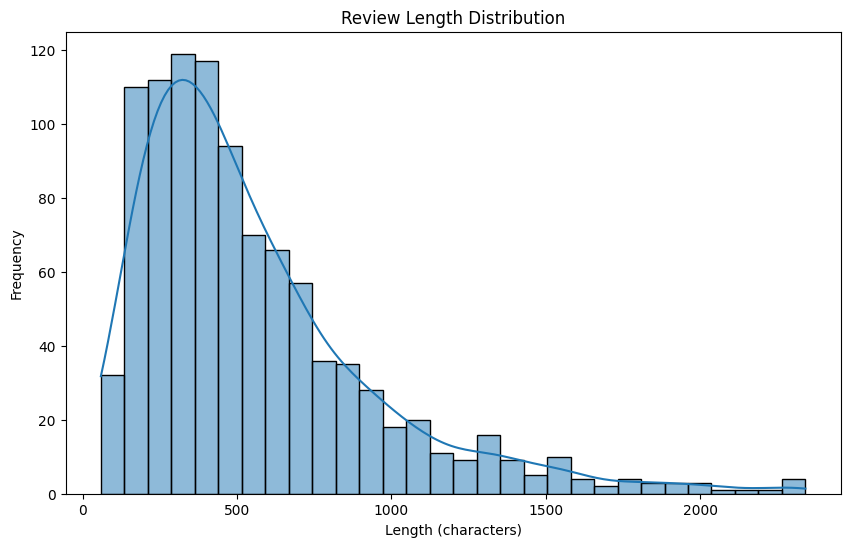


Unique words: 7085


In [4]:
# --- Data Exploration ---

# 1. Total reviews and average length
total_reviews = len(df)
avg_length = df['clean_review'].apply(len).mean()
print(f"Total reviews: {total_reviews}")
print(f"Average review length: {avg_length:.2f} characters")

# 2. Top 10 most frequent words
all_words = ' '.join(df['clean_review']).split()
word_counts = Counter(all_words)
top_words = word_counts.most_common(10)

print("\nTop 10 most frequent words:")
for word, count in top_words:
    print(f"{word}: {count}")

# 3. Distribution of review lengths
lengths = df['clean_review'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(lengths, bins=30, kde=True)
plt.title("Review Length Distribution")
plt.xlabel("Length (characters)")
plt.ylabel("Frequency")
plt.show()

# 4. Count of unique words
unique_words = len(set(all_words))
print(f"\nUnique words: {unique_words}")


## 5. Sentiment Analysis  

Sentiment analysis was performed to classify each review as Positive, Negative, or Neutral. The process included:  
- Calculating polarity scores for each review using `TextBlob`.  
- Assigning sentiment labels based on the polarity score:  
  - Positive: score > 0.1  
  - Negative: score < -0.1  
  - Neutral: score between -0.1 and 0.1  


In [5]:
# --- Sentiment Analysis Functions ---
def get_sentiment(text):
    """
    Returns the sentiment polarity score of the given text.
    Score ranges from -1 (very negative) to 1 (very positive).
    """
    return TextBlob(text).sentiment.polarity

def classify_sentiment(score):
    """
    Classifies the sentiment score into a label:
    - positive if > 0.1
    - negative if < -0.1
    - neutral otherwise
    """
    if score > 0.1:
        return "positive"
    elif score < -0.1:
        return "negative"
    else:
        return "neutral"

# --- Apply Sentiment Analysis ---
df["sentiment_score"] = df["clean_review"].apply(get_sentiment)
df["sentiment_label"] = df["sentiment_score"].apply(classify_sentiment)

# --- Display the distribution ---
print("\nSentiment Distribution:")
print(df["sentiment_label"].value_counts(normalize=True).round(2))



Sentiment Distribution:
sentiment_label
neutral     0.42
positive    0.40
negative    0.18
Name: proportion, dtype: float64


## 6. Visualization of Sentiment Analysis  

A bar chart was created to display the distribution of sentiment labels across all reviews. This chart highlights the proportion of positive, neutral, and negative reviews. 

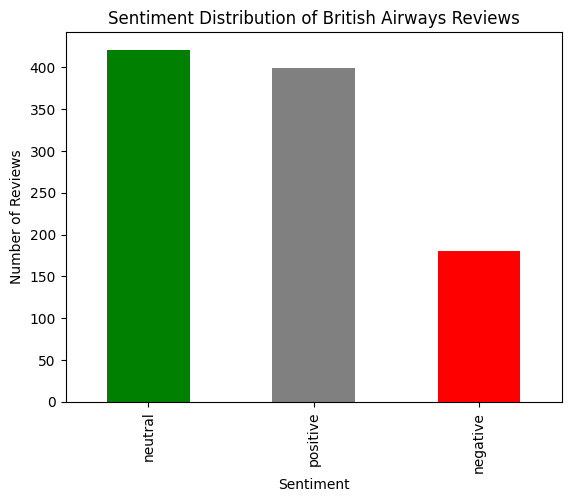

In [6]:
# --- Plot Sentiment Distribution ---
df["sentiment_label"].value_counts().plot(kind="bar", color=["green", "grey", "red"])
plt.title("Sentiment Distribution of British Airways Reviews")
plt.ylabel("Number of Reviews")
plt.xlabel("Sentiment")
plt.show()

## 7. Word Clouds for Positive and Negative Reviews  

Word clouds were generated to illustrate the most frequent words within each sentiment category.  

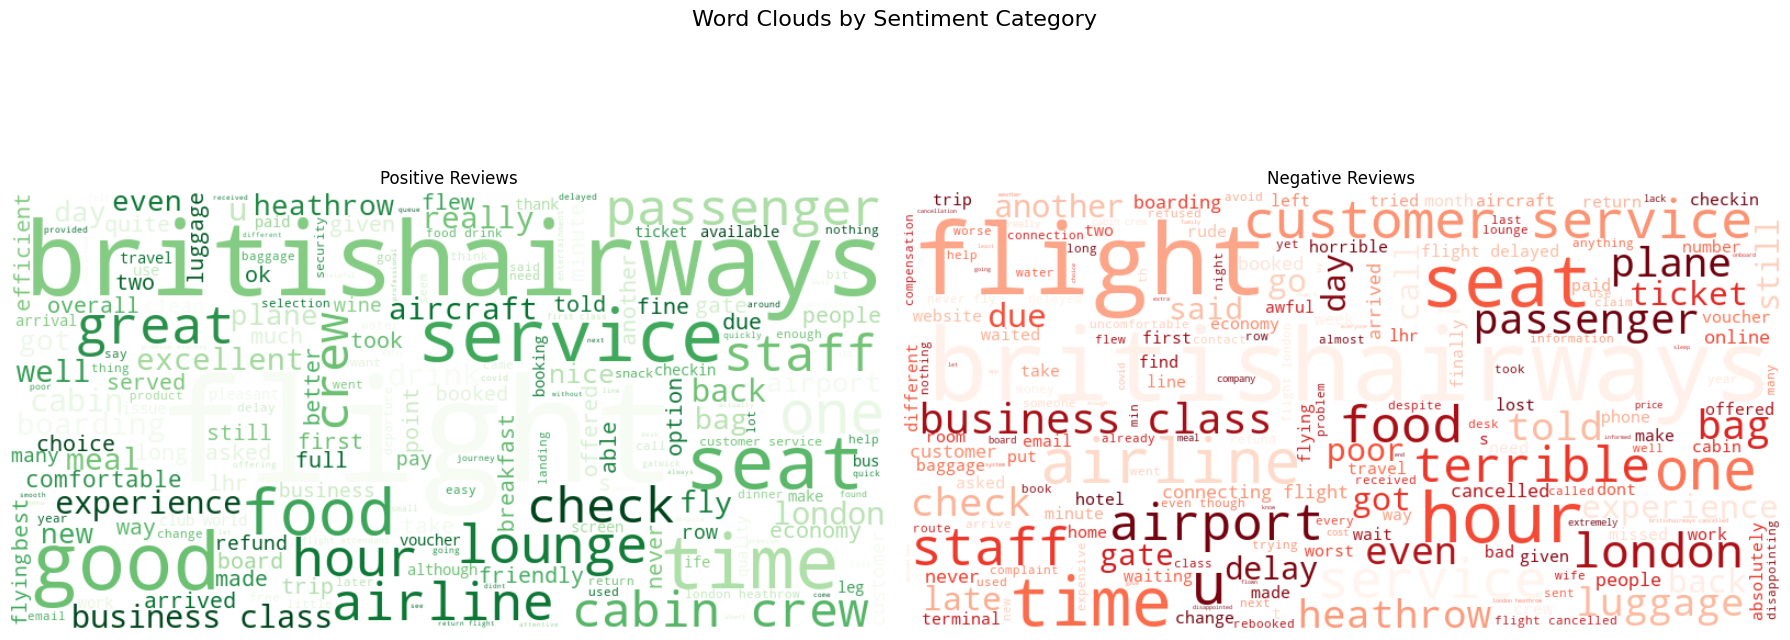

In [7]:
# --- Prepare Text for Word Clouds ---
positive_text = " ".join(df[df["sentiment_label"] == "positive"]["clean_review"])
negative_text = " ".join(df[df["sentiment_label"] == "negative"]["clean_review"])

# --- Generate Word Clouds ---
positive_wc = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(positive_text)
negative_wc = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(negative_text)

# --- Plot Word Clouds ---
fig, axs = plt.subplots(1, 2, figsize=(18, 8))

axs[0].imshow(positive_wc, interpolation='bilinear')
axs[0].axis("off")
axs[0].set_title("Positive Reviews")

axs[1].imshow(negative_wc, interpolation='bilinear')
axs[1].axis("off")
axs[1].set_title("Negative Reviews")

plt.suptitle("Word Clouds by Sentiment Category", fontsize=16)
plt.tight_layout()
plt.show()


## 8. Descriptive Analysis of Sentiment Scores  

The distribution of sentiment scores was visualized and the average sentiment score per category was calculated:  
- Histogram of sentiment score distribution  
- Boxplot showing the spread of sentiment scores  
- Bar chart comparing average sentiment scores by category  


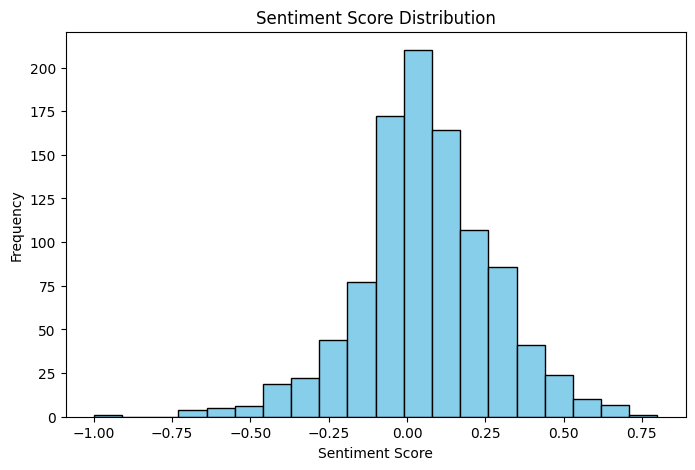

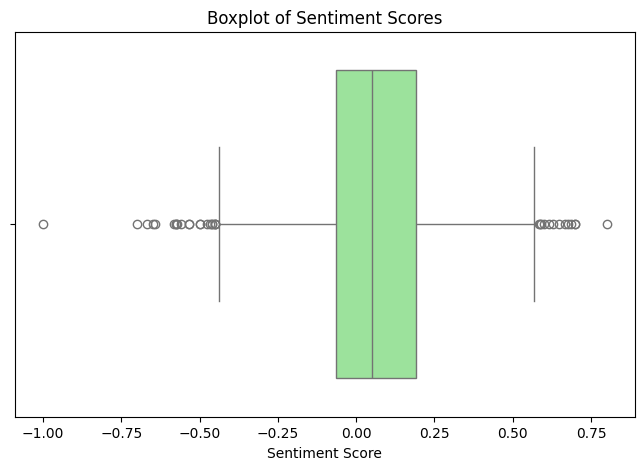


Average Sentiment Score by Category:
sentiment_label
negative   -0.252894
neutral     0.001588
positive    0.262683
Name: sentiment_score, dtype: float64


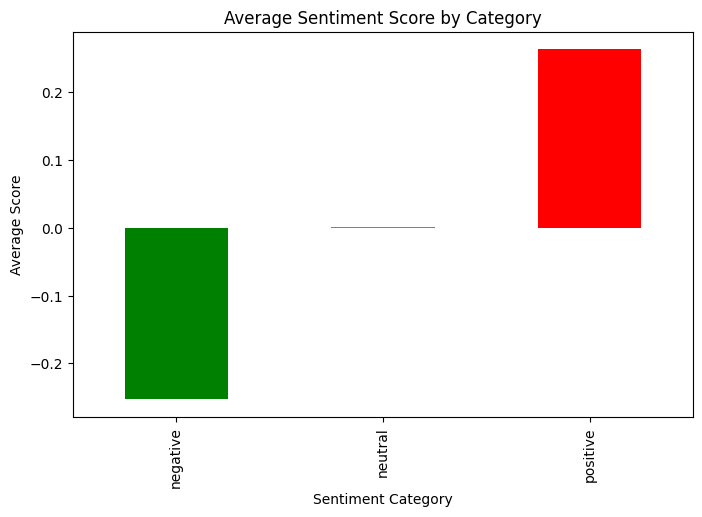

In [8]:
# --- Histogram of Sentiment Scores ---
plt.figure(figsize=(8, 5))
plt.hist(df["sentiment_score"], bins=20, color='skyblue', edgecolor='black')
plt.title('Sentiment Score Distribution')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

# --- Boxplot to visualize the spread ---
plt.figure(figsize=(8, 5))
sns.boxplot(x=df["sentiment_score"], color='lightgreen')
plt.title('Boxplot of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.show()

# --- Average Sentiment by Category ---
sentiment_means = df.groupby("sentiment_label")["sentiment_score"].mean()
print("\nAverage Sentiment Score by Category:")
print(sentiment_means)

# --- Bar Plot for Average Scores ---
plt.figure(figsize=(8, 5))
sentiment_means.plot(kind='bar', color=['green', 'grey', 'red'])
plt.title('Average Sentiment Score by Category')
plt.xlabel('Sentiment Category')
plt.ylabel('Average Score')
plt.show()

## 10. N-grams Analysis (Bigrams and Trigrams)  

Common phrases were examined by extracting:  
- **Bigrams**: sequences of two consecutive words  
- **Trigrams**: sequences of three consecutive words  

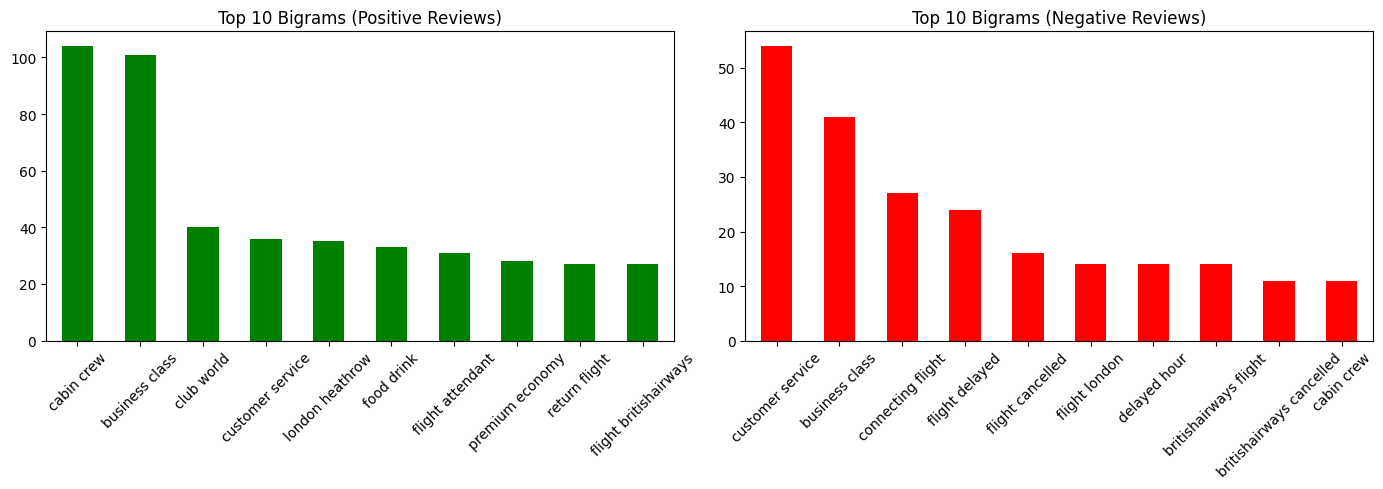

In [9]:
# --- Prepare text subsets ---
positive_reviews = df[df["sentiment_label"] == "positive"]["clean_review"]
negative_reviews = df[df["sentiment_label"] == "negative"]["clean_review"]

# --- Independent vectorizers for bigrams ---
bigram_vectorizer_pos = CountVectorizer(ngram_range=(2, 2), stop_words='english')
bigram_vectorizer_neg = CountVectorizer(ngram_range=(2, 2), stop_words='english')

# --- Fit and transform each subset ---
bigrams_pos = bigram_vectorizer_pos.fit_transform(positive_reviews)
bigrams_neg = bigram_vectorizer_neg.fit_transform(negative_reviews)

# --- Count frequencies ---
bigram_freq_pos = (
    pd.DataFrame(
        bigrams_pos.toarray(),
        columns=bigram_vectorizer_pos.get_feature_names_out()
    )
    .sum()
    .sort_values(ascending=False)
)

bigram_freq_neg = (
    pd.DataFrame(
        bigrams_neg.toarray(),
        columns=bigram_vectorizer_neg.get_feature_names_out()
    )
    .sum()
    .sort_values(ascending=False)
)

# --- Visualize top 10 bigrams for each sentiment ---
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
bigram_freq_pos.head(10).plot(kind='bar', color='green')
plt.title('Top 10 Bigrams (Positive Reviews)')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
bigram_freq_neg.head(10).plot(kind='bar', color='red')
plt.title('Top 10 Bigrams (Negative Reviews)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

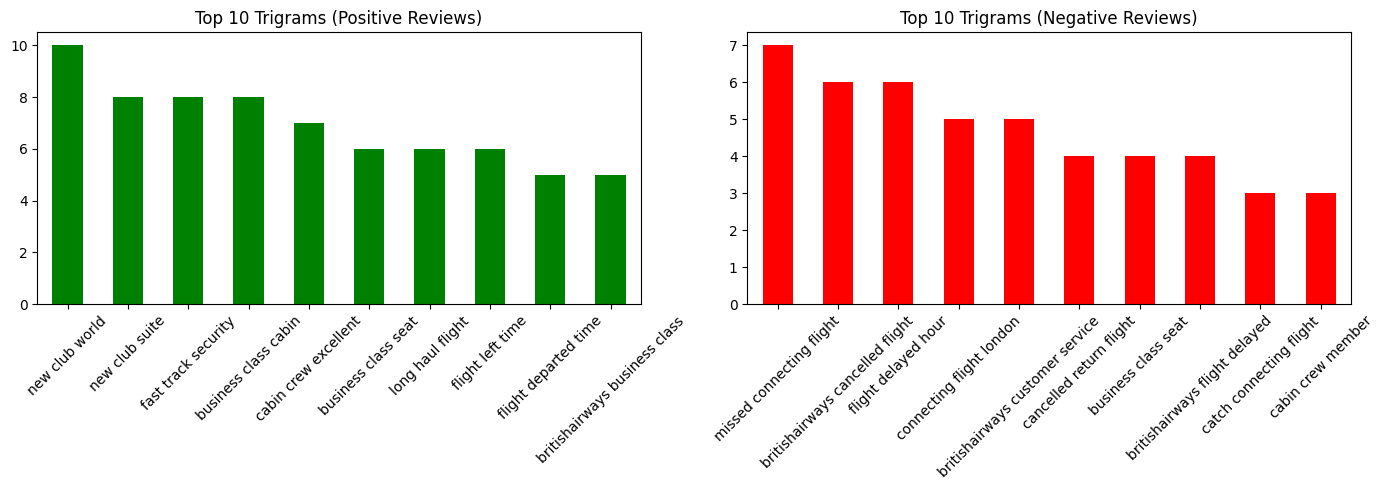

In [10]:
# --- Prepare text subsets ---
positive_reviews = df[df["sentiment_label"] == "positive"]["clean_review"]
negative_reviews = df[df["sentiment_label"] == "negative"]["clean_review"]

# --- Independent vectorizers for trigrams ---
trigram_vectorizer_pos = CountVectorizer(ngram_range=(3, 3), stop_words='english')
trigram_vectorizer_neg = CountVectorizer(ngram_range=(3, 3), stop_words='english')

# --- Fit & transform each subset ---
trigrams_pos = trigram_vectorizer_pos.fit_transform(positive_reviews)
trigrams_neg = trigram_vectorizer_neg.fit_transform(negative_reviews)

# --- Count frequencies ---
trigram_freq_pos = (
    pd.DataFrame(
        trigrams_pos.toarray(),
        columns=trigram_vectorizer_pos.get_feature_names_out()
    )
    .sum()
    .sort_values(ascending=False)
)

trigram_freq_neg = (
    pd.DataFrame(
        trigrams_neg.toarray(),
        columns=trigram_vectorizer_neg.get_feature_names_out()
    )
    .sum()
    .sort_values(ascending=False)
)

# --- Visualize top 10 trigrams for each sentiment ---
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
trigram_freq_pos.head(10).plot(kind='bar', color='green')
plt.title('Top 10 Trigrams (Positive Reviews)')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
trigram_freq_neg.head(10).plot(kind='bar', color='red')
plt.title('Top 10 Trigrams (Negative Reviews)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


## 9. Topic Modeling with LDA  

Latent Dirichlet Allocation (LDA) was applied to the cleaned reviews to uncover four key themes and quantify their prevalence. Steps performed:  
- Transform reviews into a document–term matrix using `CountVectorizer`.  
- Train an LDA model with 4 topics.  
- Extract the top 10 representative words for each topic.  
- Compute and visualize the average prevalence of each topic across all reviews.  

Topic 0: flight britishairways hour customer service day airline told cancelled time
Topic 1: britishairways flight hour staff seat crew time plane airline service
Topic 2: seat flight britishairways good class food business service time crew
Topic 3: flight britishairways cabin crew service time london staff gate bag


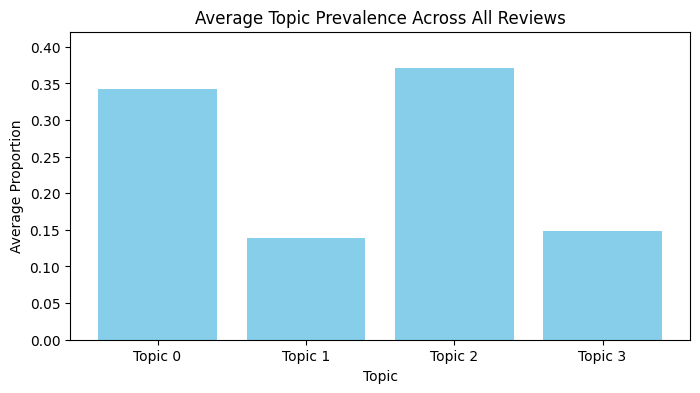

In [11]:
# --- Topic Modeling with LDA ---

# 1) Vectorize the cleaned text
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
doc_term_matrix = vectorizer.fit_transform(df["clean_review"])

# 2) Train the LDA model
lda_model = LatentDirichletAllocation(n_components=4, random_state=42)
lda_model.fit(doc_term_matrix)

# 3) Extract top words per topic
def display_topics(model, feature_names, num_top_words):
    topics = {}
    for idx, topic in enumerate(model.components_):
        top_features = " ".join(
            [feature_names[i] for i in topic.argsort()[:-num_top_words-1:-1]]
        )
        topics[f"Topic {idx}"] = top_features
    return topics

num_top_words = 10
topics = display_topics(lda_model, vectorizer.get_feature_names_out(), num_top_words)
for topic, words in topics.items():
    print(f"{topic}: {words}")

# 4) Compute average topic prevalence
doc_topic_dists = lda_model.transform(doc_term_matrix)
topic_prevalence = doc_topic_dists.mean(axis=0)

# 5) Visualize topic prevalence
plt.figure(figsize=(8, 4))
plt.bar(
    [f"Topic {i}" for i in range(len(topic_prevalence))],
    topic_prevalence,
    color="skyblue"
)
plt.title("Average Topic Prevalence Across All Reviews")
plt.xlabel("Topic")
plt.ylabel("Average Proportion")
plt.ylim(0, topic_prevalence.max() + 0.05)
plt.show()
